In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.utils import get_aligned_ids
from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, Crossval
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists

def get_row_col_names(connectivity_data, target_ordering):
    
    rnames = np.asarray([ia_map[target_ordering[i]] for i in range(len(target_ordering))])
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
    cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])
    ccomb = np.vstack([np.concatenate([np.repeat('ipsi',connectivity_data.ipsi_target_regions.shape[0]),
                                       np.repeat('contra',connectivity_data.contra_target_regions.shape)]), cnames])
    ccomb = np.asarray(ccomb)
    tuples2 = list(zip(*ccomb))
    cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
    return(cnam_multi, rnames)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structures.npy')
major_structure_ids = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/major_structure_ids.npy')
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_leaves_v3.npy')


ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ontological_order_leaves_majors = get_aligned_ids(st,ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(st,ontological_order_leaves,ontological_order)

annotation/ccf_2017


In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(major_structure_ids)

connectivity_data.ai_map = ai_map
connectivity_data.get_crelines(data_info)
connectivity_data.get_summarystructures(data_info)
connectivity_data.summary_structures = {sid: connectivity_data.structure_datas[sid].summary_structures for sid in major_structure_ids}#get_indices_2ormore(connectivity_data.leafs)
connectivity_data.leafs = leafs

sid0 = list(connectivity_data.structure_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
targ_ord = ontological_order_leaves
source_ord = ontological_order_leaves
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=1)
#ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=2)
connectivity_data.get_regionalized_normalized_data(source_ord, ipsi_targetkey, contra_targetkey)
summary_structures = {sid: connectivity_data.structure_datas[sid].summary_structures for sid in major_structure_ids}#get_indices_2ormore(connectivity_data.leafs)

512
703
1089
1097
315
313
354
698
771
803
477
549


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:225: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_inj_vcount_norm, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:229: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/connectivity_data.py:229: RuntimeWarning: invalid value encountered in true_divide
  np.sum(reg_ipsi_inj, axis=1), 1)


In [5]:
ass = np.where(connectivity_data.creline[315] == 'Ntsr1-Cre_GN220')[0]

bss = np.where(connectivity_data.leafs[315] == ai_map['MOs5'])[0]
np.intersect1d(ass,bss)

array([], dtype=int64)

In [6]:
ass = np.where(connectivity_data.creline[315] == 'Ntsr1-Cre_GN220')[0]

bss = np.where(connectivity_data.leafs[315] == ai_map['MOs6a'])[0]
np.intersect1d(ass,bss)

array([  55,  191,  481,  851,  907, 1059])

In [7]:
ass = np.where(connectivity_data.creline[315] == 'Rbp4-Cre_KL100')[0]

bss = np.where(connectivity_data.leafs[315] == ai_map['MOs6a'])[0]
print(np.intersect1d(ass,bss))

ass = np.where(connectivity_data.creline[315] == 'Rbp4-Cre_KL100')[0]

bss = np.where(connectivity_data.leafs[315] == ai_map['MOs5'])[0]
np.intersect1d(ass,bss)

[615]


array([104, 337, 438, 724, 743, 841, 900, 967])

In [8]:
eval_cre_list = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']

In [9]:
eval_cre_list_name = ['C57BL6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']

In [10]:
#el_leafsurf_leafsmth_v3_leafleaf_

experiment_sids_surfaces = leafs
experiment_sids_nws = leafs
model_ordering = ontological_order_leaves_majors[5:15]#[:5]#
source_ordering_surface = ontological_order_leaves[5:15]#[:5]#
source_ordering_nw = ontological_order_leaves[5:15]#[:5]#
source_ordering = ontological_order_leaves[5:15]#[:5]#
target_ordering = ontological_order_leaves
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]
    
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/EL_leaf_0422_leafleaf.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)
 
# for c in range(len(eval_cre_list)):
#     print(c, eval_cre_list[c])
#     conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
#     connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[117:123])
#     connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_sumsurf_leafsmth_v3_leafleaf_' + str(eval_cre_list_name[c]) + '0422_visp.csv')

In [11]:
#mop more relevant layer 5 6 distinction...
source_reg = np.asarray(['MOp2/3', 'MOp5', 'MOp6a','MOs2/3', 'MOs5', 'MOs6a' ])


In [11]:
c = 2
cnam_multi, rnames = get_row_col_names(connectivity_data, ontological_order_leaves)
conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
connectivity_matrices_mo = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[5:15])
#connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_v3_leafleaf_' + str(eval_cre_list_name[c]) + '0422_visp.csv')

c = 3
conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
connectivity_matrices3_mo = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[5:15])


0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0
0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0


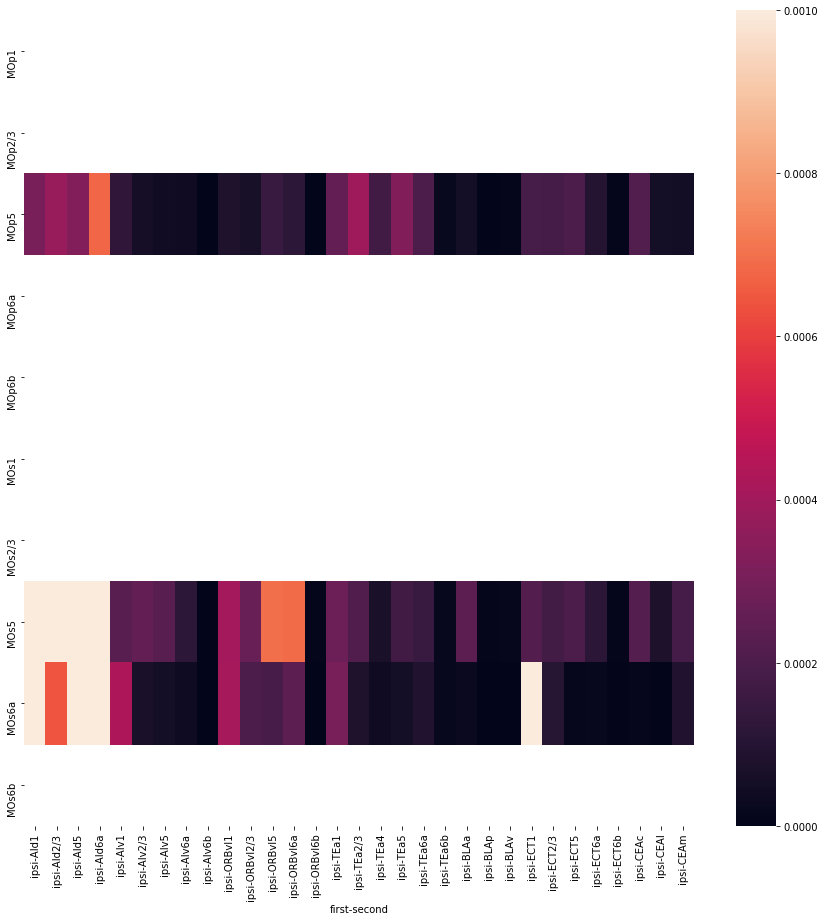

In [16]:
fig , ax = plt.subplots(figsize = (15,15))
sns.heatmap(connectivity_matrices3_mo.loc[:,targ_reg], ax= ax, vmax= .001)

In [22]:
connectivity_matrices3_mo.loc[:,('ipsi','BLAa')]

MOp1           NaN
MOp2/3         NaN
MOp5      0.000053
MOp6a          NaN
MOp6b          NaN
MOs1           NaN
MOs2/3         NaN
MOs5      0.000239
MOs6a     0.000025
MOs6b          NaN
Name: (ipsi, BLAa), dtype: float64

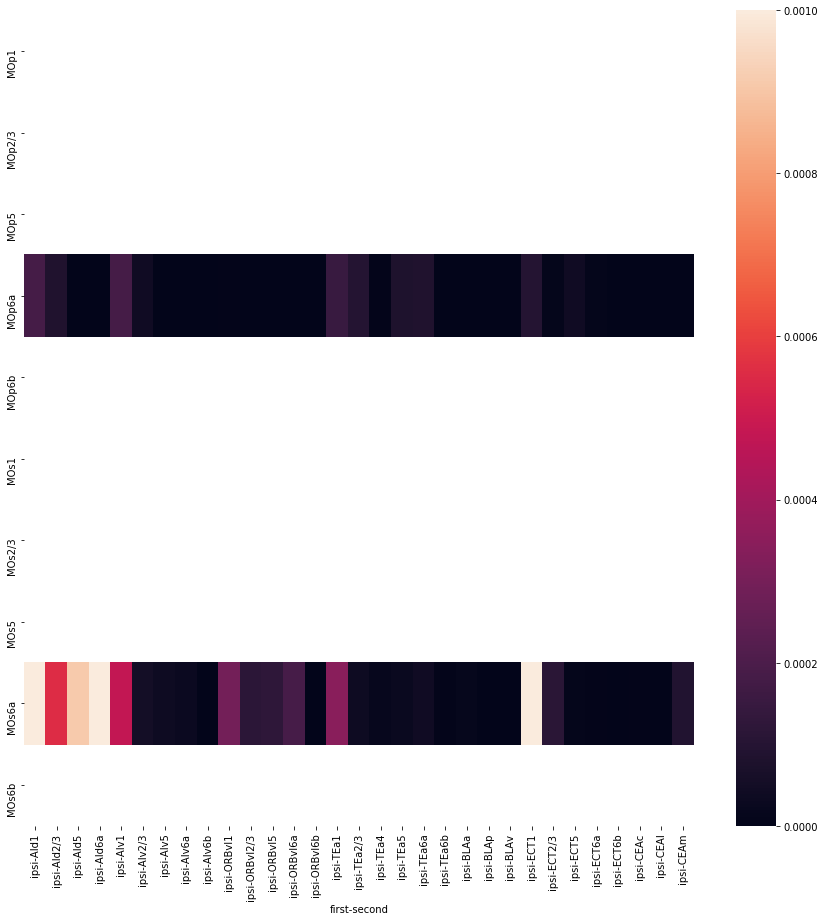

In [17]:
fig , ax = plt.subplots(figsize = (15,15))
sns.heatmap(connectivity_matrices_mo.loc[:,targ_reg], ax = ax, vmax= .001)

In [ ]:
sns.heatmap(crbp.loc[:,targ_reg], vmax = .001)

In [14]:
targ_reg = [('ipsi',      'AId1'),
('ipsi',    'AId2/3'),
('ipsi',      'AId5'),
('ipsi',     'AId6a'),
('ipsi',      'AIv1'),
('ipsi',    'AIv2/3'),
('ipsi',      'AIv5'),
('ipsi',     'AIv6a'),
('ipsi',     'AIv6b'),
('ipsi',    'ORBvl1'),
('ipsi',  'ORBvl2/3'),
('ipsi',    'ORBvl5'),
('ipsi',   'ORBvl6a'),
('ipsi',   'ORBvl6b'),
('ipsi',     'TEa1'),
('ipsi',   'TEa2/3'),
('ipsi',     'TEa4'),
('ipsi',     'TEa5'),
('ipsi',    'TEa6a'),
('ipsi',    'TEa6b'),
('ipsi',     'BLAa'),
('ipsi',     'BLAp'),
('ipsi',     'BLAv'),
('ipsi',     'ECT1'),
('ipsi',   'ECT2/3'),
('ipsi',     'ECT5'),
('ipsi',    'ECT6a'),
('ipsi',    'ECT6b'),
('ipsi',   'CEAc'),
('ipsi',   'CEAl'),
('ipsi',   'CEAm')]

In [27]:
targ_reg = [(  'ipsi',     'ORBvl'), (  'ipsi',     'AId'),(  'ipsi',     'AIv'), (  'ipsi',     'TEa'),
            (  'ipsi',     'ECT'), (  'ipsi',     'BLA'),(  'ipsi',     'CEA')]


In [16]:
np.where(np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))]) == 'MOp2/3')

(array([6]),)

In [21]:
ia_map[ontological_order_leaves[5]]

'MOp1'

In [ ]:
#visp

In [ ]:
cnam_multi, rnames = get_row_col_names(connectivity_data, ontological_order_leaves)
for c in range(len(eval_cre_list)):
    print(c, eval_cre_list[c])
    conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
    connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[117:123])
    connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_v3_leafleaf_' + str(eval_cre_list_name[c]) + '0422_visp.csv')
    

In [37]:
experiment_sids_surfaces = summary_structures
experiment_sids_nws = leafs
model_ordering = ontological_order_leaves_majors[117:123]#[:5]#
source_ordering_surface = ontological_order_leaves_summary[117:123]
source_ordering_nw = ontological_order_leaves[117:123]#[:5]#
source_ordering = ontological_order_leaves[117:123]#[:5]#
target_ordering = ontological_order_leaves
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [39]:
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/EL_sum_0422_leafleaf.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)

for c in range(len(eval_cre_list)):
    print(c, eval_cre_list[c])
    conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
    connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[117:123])
    connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_sumsurf_leafsmth_v3_leafleaf_' + str(eval_cre_list_name[c]) + '0422_visp.csv')

0 C57BL/6J
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
1 Cux2-IRES-Cre
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
2 Ntsr1-Cre_GN220
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
3 Rbp4-Cre_KL100
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
4 Tlx3-Cre_PL56
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


In [ ]:
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/EL_leaf_0422_leafleaf.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)

for c in range(len(eval_cre_list)):
    print(c, eval_cre_list[c])
    conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
    connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames)
    connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_sumsurf_sumsmth_v3_leafleaf_' + str(eval_cre_list[c]) + '0422_visp.csv')
    
    
    

In [20]:
experiment_sids_surfaces = summary_structures
experiment_sids_nws = summary_structures
model_ordering = ontological_order_leaves_majors#[:5]#[210:215]
source_ordering_surface = ontological_order_leaves#[:5]#[210:215]
source_ordering_nw = ontological_order_leaves#[:5]#[210:215]
source_ordering = ontological_order_leaves#[:5]#[210:215]
target_ordering = ontological_order_leaves
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [25]:
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/ELsummary_surface_0401_leafleaf.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)


In [28]:
experiment_sids_surfaces = summary_structures
experiment_sids_nws = leafs
model_ordering = ontological_order_leaves_majors#[:5]#[210:215]
source_ordering_surface = ontological_order_leaves_summary#[:5]#[210:215]
source_ordering_nw = ontological_order_leaves#[:5]#[210:215]
source_ordering = ontological_order_leaves#[:5]#[210:215]
target_ordering = ontological_order_leaves
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]
    
for c in range(len(eval_cre_list)):
    print(c, eval_cre_list[c])
    conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
    connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames)
    #connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/elsumsurfleafsmth_v3_leafleaf_' + str(eval_cre_list[c]) + '.csv')

0 C57BL/6J
0 68.0
1 667.0
2 526157192.0
3 526157196.0
4 526322264.0
5 320.0
6 943.0


KeyboardInterrupt: 

In [8]:
ia_map[int(source_ordering[0])]

'RSPv6a'

In [13]:
leaf_source = np.asarray([ia_map[int(ontological_order_leaves[i])] for i in range(len(ontological_order_leaves))])
np.where(leaf_source == 'VISp1')

(array([117]),)

In [14]:
leaf_source[117:123]

array(['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'],
      dtype='<U10')

In [8]:
#check leaf-leaf smooth are different for each

experiment_sids_surfaces = leafs
experiment_sids_nws = leafs
model_ordering = ontological_order_leaves_majors[117:123]#[:5]#
source_ordering_surface = ontological_order_leaves[117:123]#[:5]#
source_ordering_nw = ontological_order_leaves[117:123]#[:5]#
source_ordering = ontological_order_leaves[117:123]#[:5]#
target_ordering = ontological_order_leaves
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]
    
with open('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/trainedmodels/EL_leaf_0422_leafleaf.pickle', 'rb') as handle:
    surfaces = pickle.load(handle)

cnam_multi, rnames = get_row_col_names(connectivity_data, ontological_order_leaves)
#for c in range(len(eval_cre_list)):
#print(c, eval_cre_list[c])

    

0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


In [9]:
c = 2
conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
connectivity_matrices = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[117:123])
#connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_v3_leafleaf_' + str(eval_cre_list_name[c]) + '0422_visp.csv')

c = 3
conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
connectivity_matrices3 = pd.DataFrame(conn_v3[0], columns = cnam_multi, index=rnames[117:123])


0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


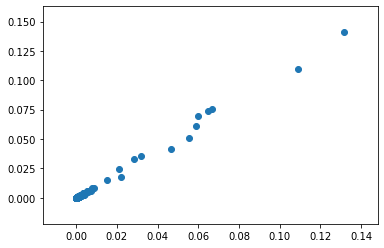

In [14]:
plt.scatter(connectivity_matrices3.iloc[4], connectivity_matrices.iloc[4])

In [16]:
diff = np.abs(connectivity_matrices3.iloc[4] - connectivity_matrices.iloc[4])

In [18]:
diff.iloc[diff.argsort()]

first   second
ipsi    III       0.000000
contra  IV        0.000000
        Su3       0.000000
        PD        0.000000
        ASO       0.000000
                    ...   
ipsi    VISp1     0.004520
        VISp5     0.008950
        LP        0.009174
        LGd-co    0.009269
        LD        0.009420
Name: VISp6a, Length: 1123, dtype: float64

In [38]:
eval_cre_list_name[2],eval_cre_list_name[3]

('Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100')

In [22]:
connectivity_matrices3

first        ipsi                                                      \
second       FRP1        FRP2/3      FRP5         FRP6a         FRP6b   
VISp1         NaN           NaN       NaN           NaN           NaN   
VISp2/3       NaN           NaN       NaN           NaN           NaN   
VISp4         NaN           NaN       NaN           NaN           NaN   
VISp5    0.000035  1.055993e-05  0.000023  7.460149e-06  5.818519e-08   
VISp6a   0.000037  4.224043e-07  0.000001  3.108734e-07  7.673502e-11   
VISp6b        NaN           NaN       NaN           NaN           NaN   

first                                                      ...    contra  \
second       MOp1    MOp2/3      MOp5     MOp6a     MOp6b  ...     ANcr1   
VISp1         NaN       NaN       NaN       NaN       NaN  ...       NaN   
VISp2/3       NaN       NaN       NaN       NaN       NaN  ...       NaN   
VISp4         NaN       NaN       NaN       NaN       NaN  ...       NaN   
VISp5    0.000459  0.000238  0.000122  0.000462  0.000042  ...  0.000300   
VISp6a   0.000385  0.000148  0.000045  0.000429  0.000044  ...  0.000087   
VISp6b        NaN       NaN       NaN       NaN       NaN  ...       NaN   

first                                                                \
second      ANcr2       PRM      COPY       PFL        FL        FN   
VISp1         NaN       NaN       NaN       NaN       NaN       NaN   
VISp2/3       NaN       NaN       NaN       NaN       NaN       NaN   
VISp4         NaN       NaN       NaN       NaN       NaN       NaN   
VISp5    0.000223  0.000418  0.000315  0.000886  0.000123  0.000012   
VISp6a   0.000146  0.000211  0.000174  0.001230  0.000268  0.000001   
VISp6b        NaN       NaN       NaN       NaN       NaN       NaN   

first                                          
second             IP            DN      VeCB  
VISp1             NaN           NaN       NaN  
VISp2/3           NaN           NaN       NaN  
VISp4             NaN           NaN       NaN  
VISp5    1.428991e-05  9.315260e-06  0.000012  
VISp6a   9.380064e-07  2.207537e-07  0.000004  
VISp6b            NaN           NaN       NaN  

[6 rows x 1123 columns]

In [24]:
crelines

NameError: name 'crelines' is not defined

In [32]:
connectivity_data.creline[315][np.where(connectivity_data.leafs[315] == 33)[0]]

array(['Penk-IRES2-Cre-neo', 'Efr3a-Cre_NO108', 'Syt6-Cre_KI148',
       'Ntsr1-Cre_GN220', 'Penk-IRES2-Cre-neo', 'Ntsr1-Cre_GN220',
       'Ntsr1-Cre_GN220', 'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100',
       'Ntsr1-Cre_GN220', 'Ntsr1-Cre_GN220', 'Ntsr1-Cre_GN220',
       'Ntsr1-Cre_GN220', 'Npr3-IRES2-Cre', 'Gpr26-Cre_KO250',
       'Ctgf-T2A-dgCre', 'Ntsr1-Cre_GN220', 'Emx1-IRES-Cre',
       'Ntsr1-Cre_GN220', 'Ntsr1-Cre_GN220', 'Ntsr1-Cre_GN220',
       'Syt6-Cre_KI148', 'Ctgf-T2A-dgCre', 'Ntsr1-Cre_GN220',
       'Syt6-Cre_KI148', 'Rbp4-Cre_KL100'], dtype=object)

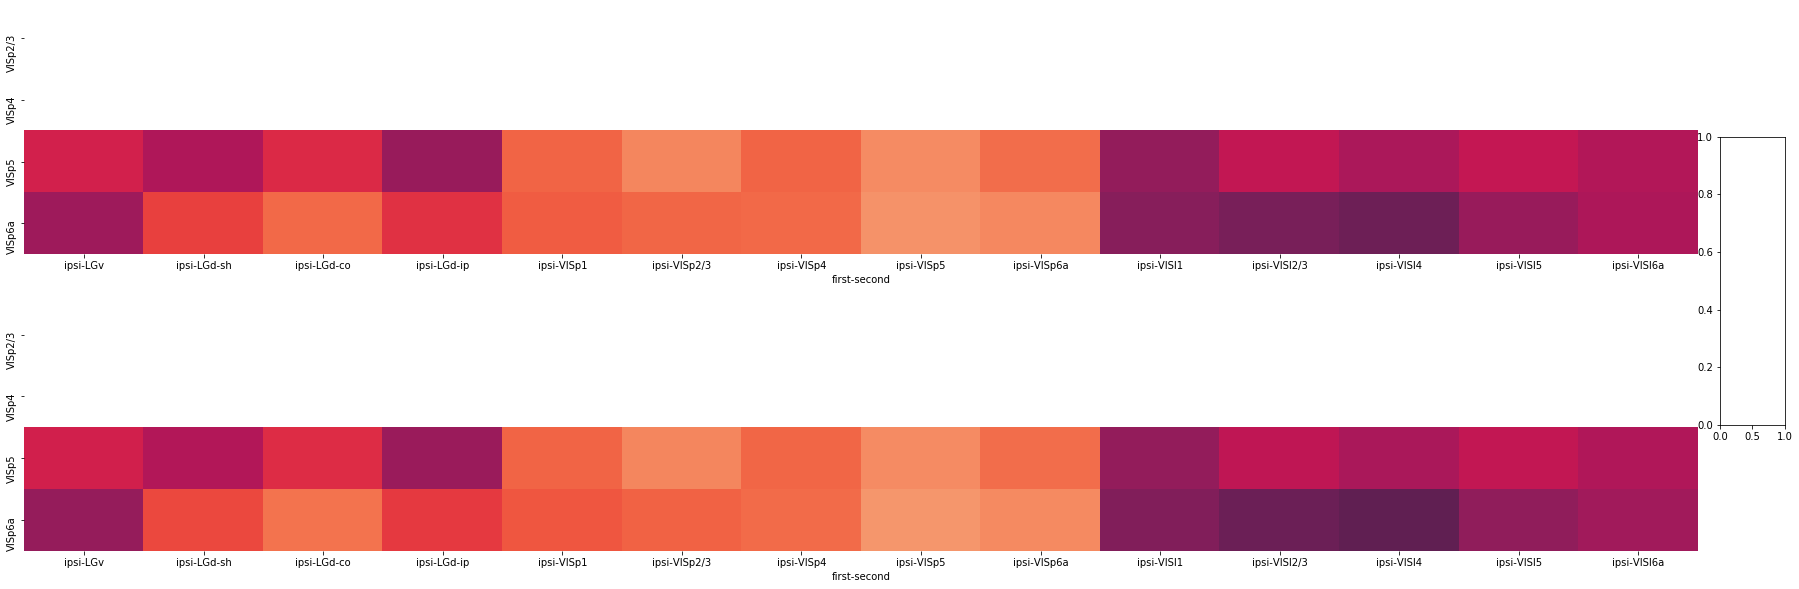

In [36]:
fig, axes = plt.subplots(2,1, figsize = (30,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

tp = np.log(connectivity_matrices3.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[0], cbar = False)

# tp = np.log(wt_conn.loc[source_reg].loc[:,targ_reg])
# tp.iloc[np.where(tp < -9)] = -9
# sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,0], cbar = False)

tp = np.log(connectivity_matrices.loc[source_regions].loc[:,target_regions])
tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1], cbar = False)

# tp = np.log(Tlx3_conn.loc[source_reg].loc[:,targ_reg])
# tp.iloc[np.where(tp < -9)] = -9
# sns.heatmap(tp, vmin = -9, vmax= 0., ax= axes[1,4], cbar = True,cbar_ax= cbar_ax) #cbar_kws={'label': 'Log projection strength'})
#plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/visp_mo_1201')


In [34]:
source_regions = np.asarray(['VISp2/3', 'VISp4', 'VISp5', 'VISp6a'])#,'VISl4', 'VISl5', 'VISl6a'])
target_regions = [(  'ipsi',     'LGv'), (  'ipsi',     'LGd-sh'),
                  (  'ipsi',     'LGd-co'),
                  (  'ipsi',     'LGd-ip'),
                  (  'ipsi',     'VISp1'),
                  (  'ipsi',     'VISp2/3'),
                  (  'ipsi',     'VISp4'),
                  (  'ipsi',     'VISp5'),
                  (  'ipsi',     'VISp6a'),
                  (  'ipsi',     'VISl1'),
                 (  'ipsi',     'VISl2/3'),
                 (  'ipsi',     'VISl4'),
                 (  'ipsi',     'VISl5'),
                 (  'ipsi',     'VISl6a')]


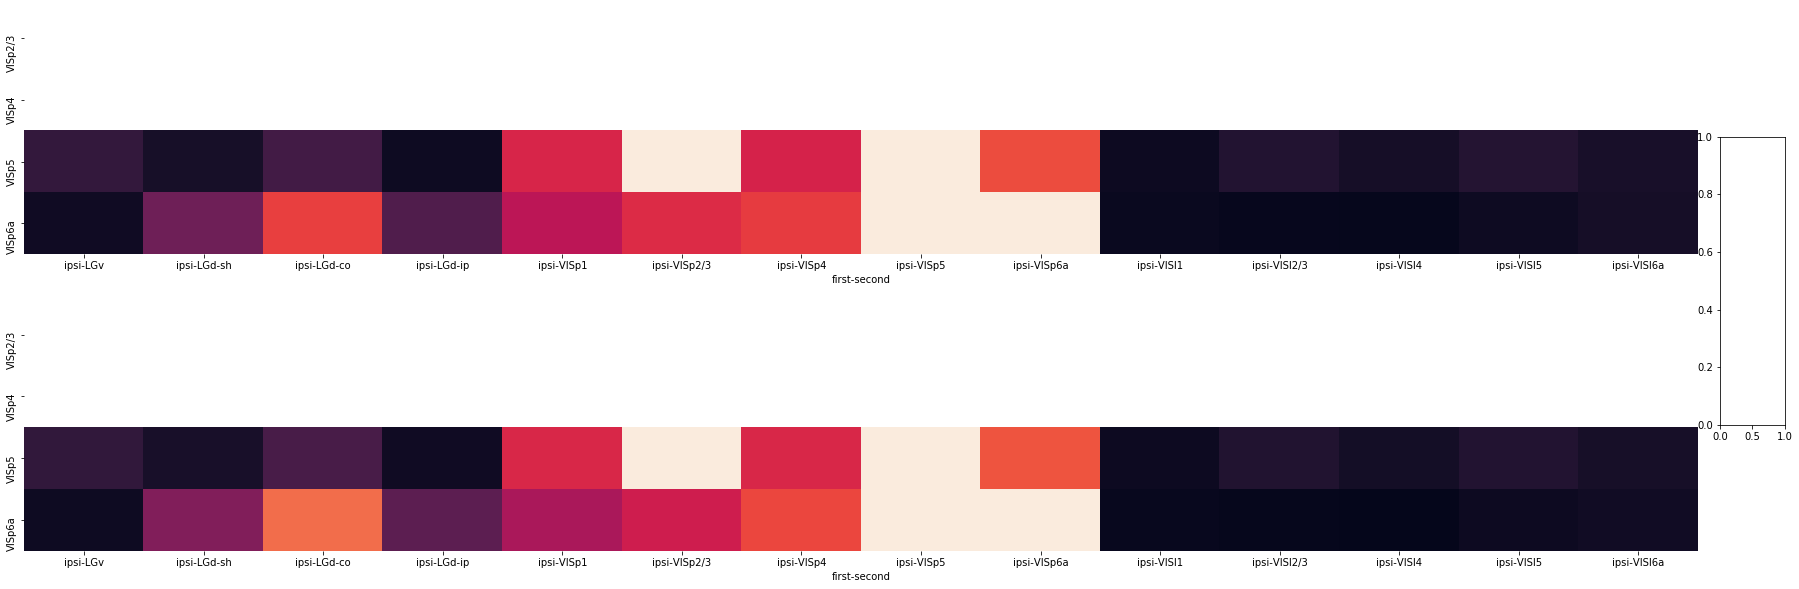

In [37]:
fig, axes = plt.subplots(2,1, figsize = (30,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

tp = connectivity_matrices3.loc[source_regions].loc[:,target_regions]
#tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -0, vmax= 0.1, ax= axes[0], cbar = False)


tp = connectivity_matrices.loc[source_regions].loc[:,target_regions]
#tp.iloc[np.where(tp < -9)] = -9
sns.heatmap(tp, vmin = -0, vmax= 0.1, ax= axes[1], cbar = False)



In [38]:
connectivity_data.leafs[315].shape

(1128,)

In [40]:
connectivity_data.creline[315].shape

(1128,)

In [23]:

# def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
#     nsource = len(source_ordering)
#     #n#target = len(target_ordering)
#     ncre = len(eval_cres)

#     ipsi_target_regions = connectivity_data.ipsi_target_regions
#     contra_target_regions = connectivity_data.contra_target_regions                               
#     ipsi_indices= np.asarray([])
#     contra_indices = np.asarray([])
#     for iy in target_ordering: 
#         ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
#         contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
#     ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
#     contra_indices = np.asarray(contra_indices, dtype = int)    
#     reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
#     ntarget = len(reorder)
      
#     connectivity = np.zeros((ncre, nsource, ntarget))
#     connectivity[:] = np.nan
#     #structure_major_dictionary = connectivity_data.structure_major_dictionary
#     for c in range(ncre):
#         for i in range(nsource):
#             print(i,source_ordering[i])
#             sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
#             gamma = gamma_dict[sid]
#             connectivity[c,i] = get_region_prediction2(cache,
#                                                       connectivity_data.structure_datas[sid],
#                                                       exp_structures = structures[sid],
#                                                       model_region = model_ordering[i,1],
#                                                       prediction_region= source_ordering[i],
#                                                       cre = eval_cres[c],
#                                                       gamma = gamma_dict[sid],
#                                                       cre_model = cre_model)
                                                      
#     connectivity = connectivity[:,:,reorder]                                                  
                                                      
#     return(connectivity)


def get_connectivity_matrices3nw(connectivity_data, gamma_dict,  experiment_sids_nws,
                               model_ordering,  source_ordering_nw, source_ordering,
                               target_ordering, eval_cres):
    nsource = len(source_ordering)
    ncre = len(eval_cres)
    cache = connectivity_data.cache
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions
    ipsi_indices = np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering:
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions == iy)[0]])
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions == iy)[0]])
    ipsi_indices = np.asarray(ipsi_indices, dtype=int)
    contra_indices = np.asarray(contra_indices, dtype=int)
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])
    ntarget = len(reorder)

    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    # structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i, source_ordering[i])
            sid = int(model_ordering[i])  # structure_major_dictionary[source_ordering[i]]

            structure_data = connectivity_data.structure_datas[sid]
            # prediction_sid_surface = source_ordering_surface[i]
            #experiment_sids_surface = experiment_sids_surfaces[sid]
            # prediction_sid_nw = source_ordering_nw[i]
            prediction_sid_nw = int(source_ordering_nw[i])

            experiment_sids_nw = experiment_sids_nws[sid]
            prediction_region = source_ordering[i]
            cre = eval_cres[c]
            gamma = gamma_dict[sid]#surfaces[sid].gamma
            #surface = surfaces[sid]
            # print(prediction_sid_nw[0], prediction_sid_surface[0], 'yes')
            connectivity[c, i] = get_region_prediction3nw(cache,
                                                        structure_data,
                                                        prediction_sid_nw=prediction_sid_nw,
                                                        experiment_sids_nw=experiment_sids_nw,
                                                        prediction_region=prediction_region,
                                                        cre=cre,
                                                        gamma=gamma)

    connectivity = connectivity[:, :, reorder]

    return (connectivity)


def get_region_prediction3nw(cache, structure_data, prediction_region, 
                           prediction_sid_nw, experiment_sids_nw, cre, gamma):
    '''
    prediction_sid_surface: what is the sid for the surface (i.e. computing cre-means)
    experiment_sids_surface: what are the sids for the experiments w/ above
    prediction_sid_nw: what is the sid for Nadaraya-Watson
    experiment_sids_nw: what are the sids for the experiments w/ above
    '''

    nw_exp_ind = np.where(experiment_sids_nw == prediction_sid_nw)[0]
    #surface_exp_ind = np.where(experiment_sids_surface == prediction_sid_surface)[0]

    #nexp_surface = len(surface_exp_ind)
    cres = structure_data.crelines
    cre_id  = np.where(cres == cre)[0]
    nw_exp_ind = np.intersect1d(cre_id, nw_exp_ind)
    
    mask = Mask.from_cache(cache, structure_ids=[prediction_region], hemisphere_id=2)

    projections = structure_data.reg_proj_norm[nw_exp_ind]
    centroids = structure_data.centroids[nw_exp_ind]

    #projections_surface = structure_data.reg_proj_norm[surface_exp_ind]

    if centroids.shape[0] > 0:

        if len(nw_exp_ind) > 0:
            losses = pairwise_distances(centroids, mask.coordinates) ** 2
            predictions = get_nw_predictions(projections, losses, gamma)
            
            output = np.mean(predictions, axis=0)
            #output = output / np.sum(output)#/ np.linalg.norm(output)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    else:
        output = np.zeros(projections.shape[1])
        output[:] = np.nan

    return (output)

In [24]:
from sklearn.metrics import pairwise_distances

In [25]:
gamma_dict = {315:.001}#{315:100.}

In [26]:
from mcmodels.core import Mask
from mcmodels.models.voxel.utils import get_nw_predictions


In [27]:
cdict = {}
for c in range(5):
    cdict[c] = get_connectivity_matrices3nw(connectivity_data,gamma_dict,experiment_sids_nws, model_ordering,  source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])


0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0
0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0
0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0
0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0
0 320.0
1 943.0
2 648.0
3 844.0
4 882.0
5 656.0
6 962.0
7 767.0
8 1021.0
9 1085.0


In [44]:
ontological_order_leaves[117:123]

array([593., 821., 721., 778.,  33., 305.])

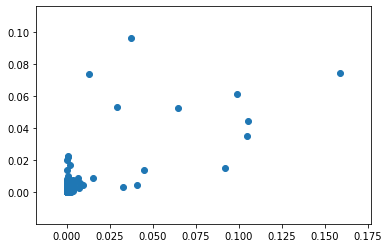

In [49]:
plt.scatter(cdict[2][0,4,:], cdict[3][0,4,:])

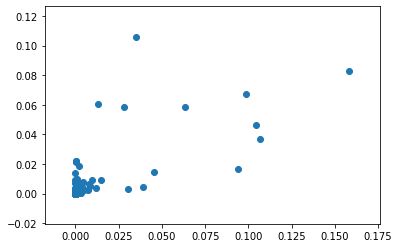

In [45]:
plt.scatter(cdict[2][0,4,:], cdict[3][0,4,:])

In [34]:
c = 2
#conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
connectivity_matrices2nw = pd.DataFrame(cdict[c][0], columns = cnam_multi, index=rnames[5:15])
#connectivity_matrices.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_v3_leafleaf_' + str(eval_cre_list_name[c]) + '0422_visp.csv')

c = 3
#conn_v3 = get_connectivity_matrices3(connectivity_data, surfaces, experiment_sids_surfaces,experiment_sids_nws, model_ordering, source_ordering_surface, source_ordering_nw, source_ordering, target_ordering, [eval_cre_list[c]])
connectivity_matrices3nw = pd.DataFrame(cdict[c][0], columns = cnam_multi, index=rnames[5:15])


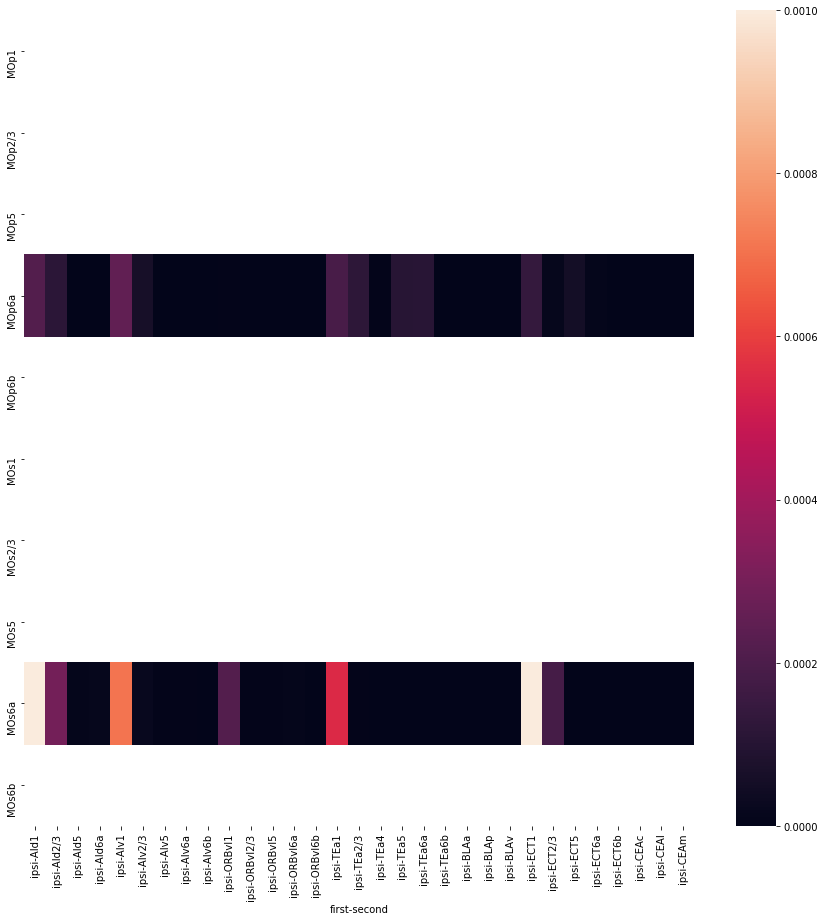

In [39]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(connectivity_matrices2nw.loc[:,targ_reg], ax = ax, vmax= .001)

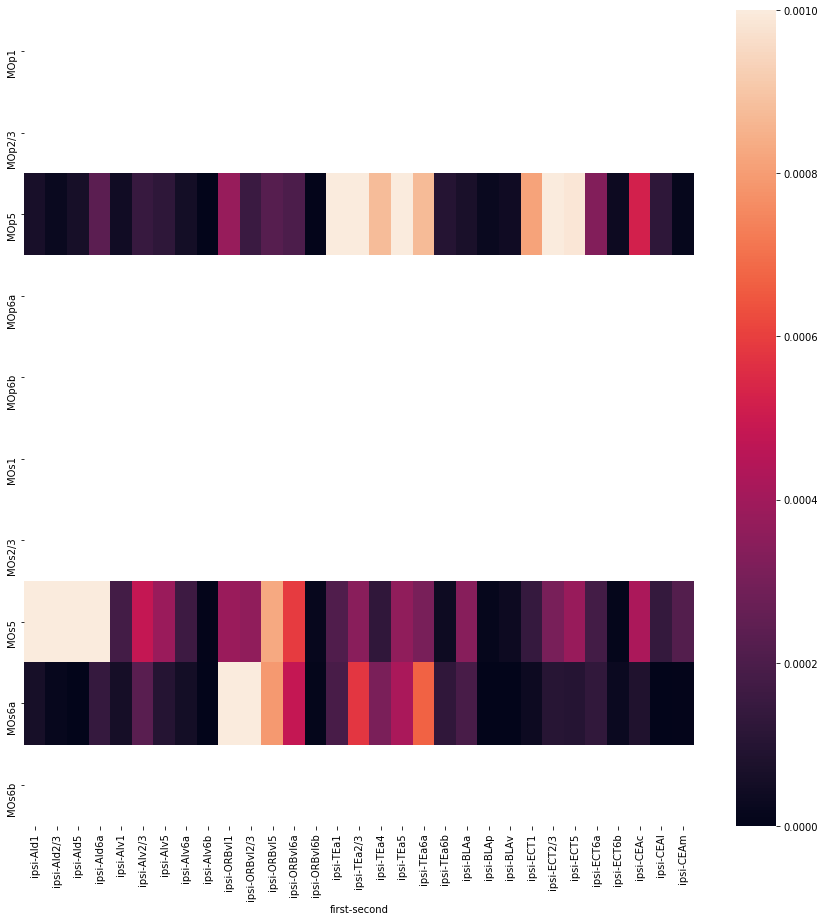

In [40]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(connectivity_matrices3nw.loc[:,targ_reg], ax = ax, vmax= .001)